# MCT4052 Workshop 4e: Clustering Evaluation Metrics

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows various clustering evaluation metrics that we can use with [K Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) in order to iidentify the best number of clusters k. Moreover, the notebook also show other clustering evaluation metrics that rely on true labels of data (for this reason in this example we will compute both features and label arrays when loading the data).

Compared to Workshop 4d, we use a different dataset and a slightly larget set of features.

In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
from mpl_toolkits import mplot3d
ms.use("seaborn-v0_8")
%matplotlib nbagg
import IPython.display as Ipd
import os
import sklearn

%matplotlib nbagg
%config IPCompleter.greedy=True

In [2]:
sr = 22050

#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features are from librosa and are all scalar (we take the mean over multiple blocks computed across the duration, which differs for each file).
#The function returns a list containing the mean of the features given an filename, and the sampling rate at which we are resampling the file
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(filename, sr=sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = [
        np.mean(librosa.feature.spectral_centroid(y=signal)),
        np.mean(librosa.feature.spectral_bandwidth(y=signal)),
        np.mean(librosa.feature.spectral_flatness(y=signal))
    ]
    
    return output


#creating an array of zeros of the proper size where we will store computed features and lables
filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),3)) #we compute the average of 3 features in the above code (3 must be changed if using more or less features)
labels = np.zeros((len(filenames))) #we store the labels as integers
classes = ['kick','snare','cymbal','clap'] #list of text labels to conver numberical labels to text labels

for i in range(len(filenames)):
    #print('processing',filenames[i])
    features[i,:] = extract_features('./data/examples2/'+filenames[i], sr)
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3

        
print('Done!')

Done!


In [3]:
print(filenames[0], "centroid is {}, bandwidth is {} and flatness is {}".format(features[0,0], 
                                                                                features[0,1], 
                                                                                features[0,2]))

snare_28.wav centroid is 3595.7158817123723, bandwidth is 2780.0782623318737 and flatness is 0.09126012772321701


In [4]:
#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling
scaler.fit(features)

#apply scaling
features = scaler.transform(features)

In [5]:
print("After standardization:\n")
print(filenames[0], "centroid is {}, bandwidth is {} and flatness is {}".format(features[0,0], 
                                                                                features[0,1], 
                                                                                features[0,2]))

After standardization:

snare_28.wav centroid is 0.8880129123251742, bandwidth is 0.9888453733683511 and flatness is -0.46110287939222966


<IPython.core.display.Javascript object>


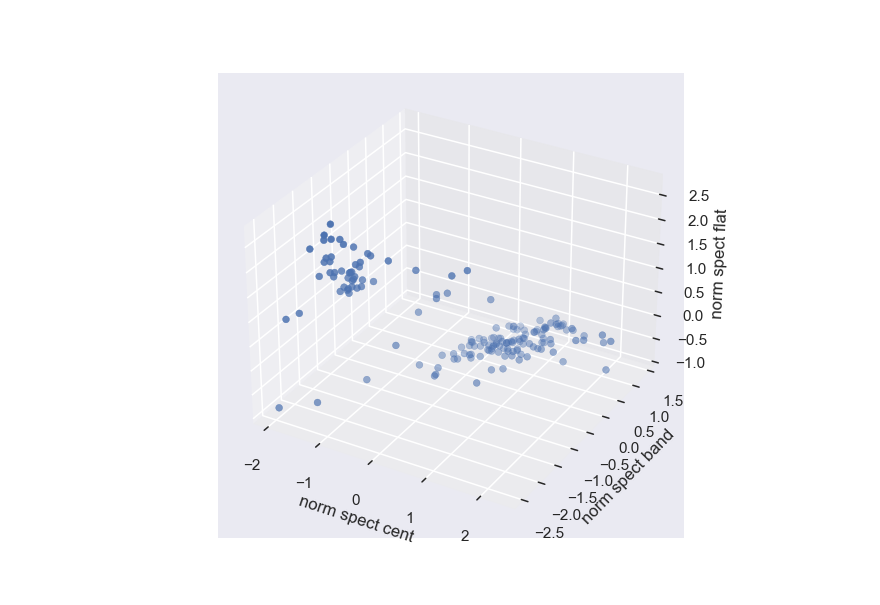

In [6]:
# displaying the features on 3D scatter plot    
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(features[:,0], features[:,1], features[:,2])
ax.set_xlabel('norm spect cent')
ax.set_ylabel('norm spect band')
ax.set_zlabel('norm spect flat');

### 1. Finding K with Elbow and Silhouette methods

With K Means we need to specify the number of clusters. If we have no expectations or knowledge about the data it can be hard to find the "best" number of clusters.

The Elbow methos is a possible approach to find computationally the right/best number of clusters. The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (i.e. clusters), in this examples we range from 1 to 10) and for each value of k, calculate sum of squared errors (SSE, also called inertia, and available as attribute in the [kmeans object](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

After that, plot a line graph of the SSE for each value of k. If the line graph looks like an arm, the "elbow" on the arm is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

So the goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In this case 2 or 3 appears to be the optimal number of clusters (i.e. value for k).

Alternatively we can use the [silhouette coefficient method](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) method. A higher [silhouette coefficient](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) score relates to a model with better-defined clusters. The silhouette coefficient is defined for each sample and is composed of two scores: `

* a: The mean distance between a sample and all other points in the same class.
* b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient is for a single sample is then given as: s=(b-a)/max(a,b)

As discussed before, to find the optimal value of k we loop, loop through 1..n for n_clusters in KMeans and calculate Silhouette Coefficient for each sample. However, the silhouette coefficient can be computed for number of clusters greater equal or greater than 2.

A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In the example below, 2 seems to be the best number of clusters according to the silhouette coefficient.

There are other clustering techniques, such as MeanShift and DBSCAN, explored in the following notebook, in which it is not necessary/possible to specify the number of clusters.

<IPython.core.display.Javascript object>


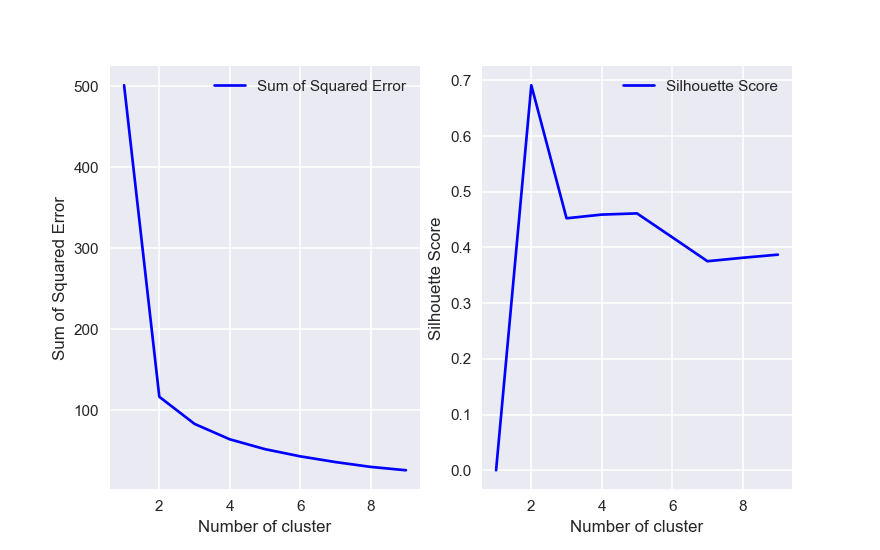

In [7]:
sse = [] #sum of squared errors
sil_coeff = [] #silhouette coefficients

range_n_clusters = range(1, 10)

for k in range_n_clusters:
    kmeans = sklearn.cluster.KMeans(n_clusters=k, max_iter=1000).fit(features)
    
    sse.append(kmeans.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
    if k < 2: # we need at least 2 clusters to compute the silhouette coefficient
        sil_coeff.append(0) # setting the silhouette coefficient to 0 for meaningless cases
    else:
        label = kmeans.labels_
        sil_coeff.append(sklearn.metrics.silhouette_score(features, label, metric='euclidean'))
         
fig = plt.figure(figsize=(8,5))
fig.add_subplot(121)
plt.plot(range_n_clusters, sse,'b-',label='Sum of Squared Error')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, sil_coeff,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

### 2. Clustering the data and plotting a color-coded 3D scatter plot.


In [8]:
#Working wiht 3 clusters
clusters = 4 #empirically, 3-4 can be used

kmeans = sklearn.cluster.KMeans(n_clusters=clusters, random_state=1)

#we are using features 
kmeans = kmeans.fit(features)

#this will generate labels as integer numbers ranging from 0 to number of clusters -1
predicted_labels = kmeans.predict(features)


<IPython.core.display.Javascript object>


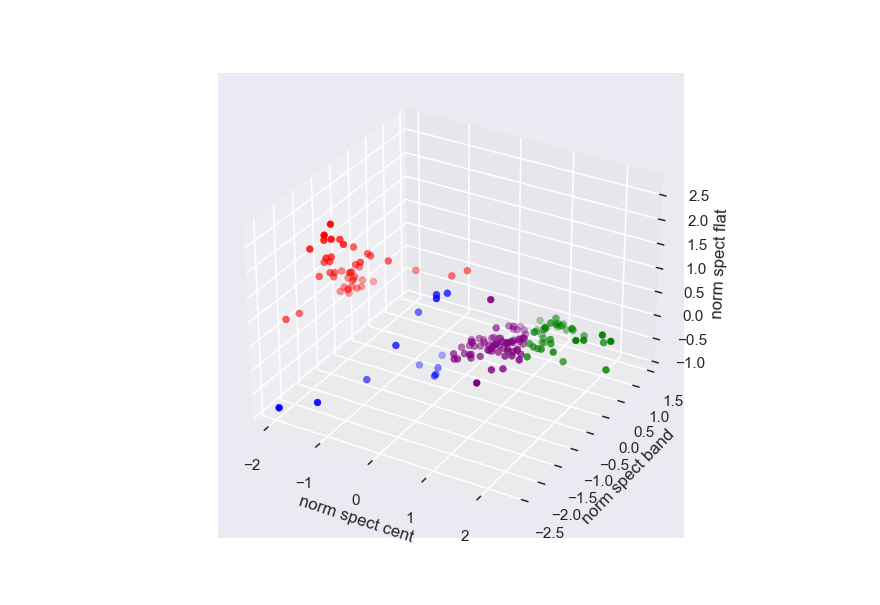

Text(0.5, 0, 'norm spect flat')

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')

colors = ['blue', 'red', 'purple', 'green', 'orange'] #the lenght of this liste must be equal or greater the number of clusters

for lab_val, col in zip(range(0,clusters),colors):
    ax.scatter3D(features[predicted_labels==lab_val, 0],
                 features[predicted_labels==lab_val, 1],
                 features[predicted_labels==lab_val, 2],
                 c=col)

ax.set_xlabel('norm spect cent')
ax.set_ylabel('norm spect band')
ax.set_zlabel('norm spect flat')
    

In [10]:
#Selecting which class (an integer from 0 to number of cluster - 1) to be "displayed",
#in the Audio widgets below
selected_cluster = 0
selected_cluster_idxs = np.asarray(np.where(predicted_labels == selected_cluster)).flatten()

for i in range(np.size(selected_cluster_idxs)):
    print('./data/examples2/'+filenames[selected_cluster_idxs[i]])
    signal, sr = librosa.load('./data/examples2/'+filenames[selected_cluster_idxs[i]], sr=sr, mono=True)
    Ipd.display(Ipd.Audio(signal, rate=sr))

./data/examples2/clap41.wav


./data/examples2/snare_10.wav


./data/examples2/clap24.wav


./data/examples2/cymbal01.wav


./data/examples2/clap19.wav


./data/examples2/clap33.wav


./data/examples2/cymbal16.wav


./data/examples2/cymbal17.wav


./data/examples2/clap26.wav


./data/examples2/clap37.wav


./data/examples2/clap20.wav


./data/examples2/clap17.wav


./data/examples2/clap29.wav


### 3. Clustering evaluation metrics

There are other evaluation metrics for clustering techniques (for a comprehensive list refer to this [tutorial](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) and [list](https://scikit-learn.org/stable/modules/model_evaluation.html)) which relies on knowing the true labels of the data (i.e. performing unsupervised machine learning with labeled/supervised data).

In this notebook we computed the labels of the data, therefore below there is a selection of emaluation metrics which uses the true labels of data. Mind that these metrics does not look for a matching of the labels, but rather for an appropriate grouping/clustering.

The scores are in the range 0 to 1 where 1 is best.

In [11]:
#computing scores (output is in range 0 to 1 where 1 is best)
print('V Measure Score:',sklearn.metrics.v_measure_score(labels, predicted_labels))
print('Homogeneity Score:',sklearn.metrics.homogeneity_score(labels, predicted_labels))
print('Completeness Score:',sklearn.metrics.completeness_score(labels, predicted_labels))


V Measure Score: 0.4200140450935073
Homogeneity Score: 0.4013047189558201
Completeness Score: 0.4405531835660898


### 4. Follow-up activity

1. Try to use either the V Measure, Homogenity or Completeness score to find the best number of clusters k.

2. Try to change/increase the number of features (mind that if more than 3 you wont be able to plot).